In [ ]:
# OUtline at https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266
# https://www.kaggle.com/mnassrib/customer-churn-prediction-telecom-churn-dataset

In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import * # module math
import matplotlib.pyplot as plt # visualization
from PIL import Image
import seaborn as sns # visualization
import itertools
import io
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from pylab import rcParams


%matplotlib inline

In [2]:
data = pd.read_csv('clean_telco.csv')

In [3]:
data.head()

,customer_id,gender,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc
0,1371-DWPAZ,Female,0,Yes,Yes,0,1,2,Credit card (automatic),56.05,...,False,False,True,3.0,20211027,0.0,False,2 Year,No Phone Service,DSL
1,2520-SGTTA,Female,0,Yes,Yes,1,0,2,Mailed check,20.00,...,False,False,True,3.0,20211027,0.0,False,2 Year,One Line,No Internet Service
2,2775-SEFEE,Male,0,No,Yes,2,1,2,Bank transfer (automatic),61.90,...,False,True,False,2.0,20211027,0.0,False,2 Year,Two or More Lines,DSL
3,2923-ARZLG,Male,0,Yes,Yes,1,0,1,Mailed check,19.70,...,False,False,True,3.0,20211027,0.0,False,1 Year,One Line,No Internet Service
4,3115-CZMZD,Male,0,No,Yes,1,0,2,Mailed check,20.25,...,False,True,False,2.0,20211027,0.0,False,2 Year,One Line,No Internet Service


In [4]:
data.shape

(7043, 30)

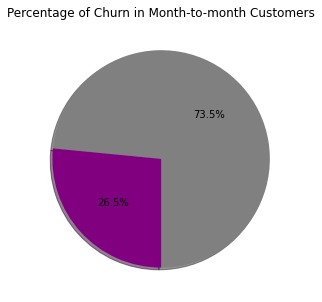

In [5]:
# Current churn rate
sizes = data['churn'].value_counts(sort = True)
colors = ['grey', 'purple']
rcParams['figure.figsize']=5,5

plt.pie(sizes, colors=colors, autopct='%1.1f%%', shadow=True, startangle=270)

plt.title('Percentage of Churn in Month-to-month Customers')
plt.show();

In [6]:
#Remove data irrelevant to correlation
data.drop('customer_id', axis=1, inplace=True)

In [10]:
#Clean data, define proper dtypes
data.dtypes


gender                          object
is_senior_citizen                int64
partner                         object
dependents                      object
phone_service                    int64
internet_service                 int64
contract_type                    int64
payment_type                    object
monthly_charges                float64
total_charges                  float64
churn                           object
tenure                           int64
is_female                         bool
has_churned                       bool
has_phone                         bool
has_internet                      bool
has_phone_and_internet            bool
partner_dependents               int64
no_partners_no_dependents         bool
no_dependents_yes_partners        bool
dependents_no_partners            bool
yes_dependents_and_partners       bool
Unnamed: 23                    float64
start_date                       int64
average_monthly_charges        float64
validate_monthly_charges 

In [9]:
# Convert types
#data['monthly_charges']=data['monthly_charges'].str.replace('$','')
#data['monthly_charges']=data['monthly_charges'].str.replace(',','').astype(float)
data['total_charges']=data['total_charges'].str.replace('$','')
data['total_charges']=data['total_charges'].str.replace(',','').astype(float)
data['average_monthly_charges']=data['average_monthly_charges'].str.replace('$','')
data['average_monthly_charges']=data['average_monthly_charges'].str.replace(',','').astype(float)




AttributeError: Can only use .str accessor with string values!

In [11]:
data.dtypes

gender                          object
is_senior_citizen                int64
partner                         object
dependents                      object
phone_service                    int64
internet_service                 int64
contract_type                    int64
payment_type                    object
monthly_charges                float64
total_charges                  float64
churn                           object
tenure                           int64
is_female                         bool
has_churned                       bool
has_phone                         bool
has_internet                      bool
has_phone_and_internet            bool
partner_dependents               int64
no_partners_no_dependents         bool
no_dependents_yes_partners        bool
dependents_no_partners            bool
yes_dependents_and_partners       bool
Unnamed: 23                    float64
start_date                       int64
average_monthly_charges        float64
validate_monthly_charges 

In [15]:
data.contract_type_desc.head(50)

12     Month-to-Month
13     Month-to-Month
14     Month-to-Month
15     Month-to-Month
16     Month-to-Month
19     Month-to-Month
23     Month-to-Month
28     Month-to-Month
30     Month-to-Month
32     Month-to-Month
33     Month-to-Month
34     Month-to-Month
35     Month-to-Month
36     Month-to-Month
47     Month-to-Month
48     Month-to-Month
50     Month-to-Month
51     Month-to-Month
55     Month-to-Month
59     Month-to-Month
60     Month-to-Month
62     Month-to-Month
63     Month-to-Month
64     Month-to-Month
65     Month-to-Month
66     Month-to-Month
67     Month-to-Month
68     Month-to-Month
72     Month-to-Month
74     Month-to-Month
75     Month-to-Month
76     Month-to-Month
77     Month-to-Month
80     Month-to-Month
81     Month-to-Month
82     Month-to-Month
83     Month-to-Month
84     Month-to-Month
86     Month-to-Month
88     Month-to-Month
89     Month-to-Month
90     Month-to-Month
92     Month-to-Month
93     Month-to-Month
95     Month-to-Month
97     Mon

In [13]:
#filter only month to month
data =data[data.contract_type_desc=='Month-to-Month']

In [14]:
data.sample(20)

,gender,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc
2931,Female,0,Yes,Yes,1,0,0,Bank transfer (automatic),19.80,196.75,...,False,False,True,3.0,20201228,19.80,True,Month-to-Month,One Line,No Internet Service
6927,Female,0,Yes,Yes,1,1,0,Electronic check,45.70,45.70,...,False,False,True,3.0,20210926,45.70,True,Month-to-Month,One Line,DSL
324,Male,0,No,No,1,0,0,Credit card (automatic),20.75,67.10,...,False,False,False,0.0,20210720,20.75,True,Month-to-Month,One Line,No Internet Service
829,Male,0,No,No,1,2,0,Electronic check,91.10,1135.70,...,False,False,False,0.0,20201012,91.10,True,Month-to-Month,One Line,Fiber Optic
2846,Female,0,Yes,Yes,1,0,0,Mailed check,20.25,401.95,...,False,False,True,3.0,20200302,20.25,True,Month-to-Month,One Line,No Internet Service
3766,Male,0,No,No,2,2,0,Bank transfer (automatic),101.55,298.35,...,False,False,False,0.0,20210729,101.55,True,Month-to-Month,Two or More Lines,Fiber Optic
6015,Male,0,No,No,1,2,0,Credit card (automatic),73.85,1424.50,...,False,False,False,0.0,20200319,73.85,True,Month-to-Month,One Line,Fiber Optic
4767,Male,0,Yes,No,2,2,0,Electronic check,114.10,7132.15,...,True,False,False,1.0,20160812,114.10,True,Month-to-Month,Two or More Lines,Fiber Optic
1730,Male,0,No,No,2,2,0,Electronic check,95.70,1451.10,...,False,False,False,0.0,20200722,95.70,True,Month-to-Month,Two or More Lines,Fiber Optic
3623,Female,0,Yes,Yes,1,2,0,Electronic check,69.80,69.80,...,False,False,True,3.0,20210926,69.80,True,Month-to-Month,One Line,Fiber Optic


In [16]:
data.shape

(3875, 29)

In [17]:
data.dtypes

gender                          object
is_senior_citizen                int64
partner                         object
dependents                      object
phone_service                    int64
internet_service                 int64
contract_type                    int64
payment_type                    object
monthly_charges                float64
total_charges                  float64
churn                           object
tenure                           int64
is_female                         bool
has_churned                       bool
has_phone                         bool
has_internet                      bool
has_phone_and_internet            bool
partner_dependents               int64
no_partners_no_dependents         bool
no_dependents_yes_partners        bool
dependents_no_partners            bool
yes_dependents_and_partners       bool
Unnamed: 23                    float64
start_date                       int64
average_monthly_charges        float64
validate_monthly_charges 

In [18]:
data.churn.head()

12     No
13    Yes
14    Yes
15    Yes
16     No
Name: churn, dtype: object

In [19]:
data.churn=data.churn.str.replace('No','0')
data.churn=data.churn.str.replace('Yes','1')

In [20]:
data.churn.head()

12    0
13    1
14    1
15    1
16    0
Name: churn, dtype: object

In [23]:
data.churn=data.churn.astype(bool)

In [24]:
data.churn.head()

12    False
13     True
14     True
15     True
16    False
Name: churn, dtype: bool

In [25]:
# Split data into training and testing set (i know I should do 3 for validation, but at this early exploration phase, I am not)

y = data["churn"].values
X = data.drop(labels = ["churn"],axis = 1)


In [26]:
#do 0 / 1 conversion on sex
data.rename(columns={'gender': 'is_male'}, inplace = True)
data.head()

,is_male,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc
12,Male,0,No,No,2,1,0,Mailed check,59.9,542.40,...,False,False,False,0.0,20210124,59.9,True,Month-to-Month,Two or More Lines,DSL
13,Male,0,No,No,1,2,0,Electronic check,73.9,280.85,...,False,False,False,0.0,20210703,73.9,True,Month-to-Month,One Line,Fiber Optic
14,Male,1,Yes,No,1,2,0,Electronic check,98.0,1237.85,...,True,False,False,1.0,20201007,98.0,True,Month-to-Month,One Line,Fiber Optic
15,Female,1,Yes,No,1,2,0,Mailed check,83.9,267.40,...,True,False,False,1.0,20210722,83.9,True,Month-to-Month,One Line,Fiber Optic
16,Female,0,No,Yes,1,1,0,Credit card (automatic),69.4,571.45,...,False,True,False,2.0,20210218,69.4,True,Month-to-Month,One Line,DSL


In [27]:
data.is_male=data.is_male.str.replace('Male','1')
data.is_male=data.is_male.str.replace('Female','0')
data.is_male=data.is_male.astype(bool)

In [28]:
data.head()

,is_male,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc
12,True,0,No,No,2,1,0,Mailed check,59.9,542.40,...,False,False,False,0.0,20210124,59.9,True,Month-to-Month,Two or More Lines,DSL
13,True,0,No,No,1,2,0,Electronic check,73.9,280.85,...,False,False,False,0.0,20210703,73.9,True,Month-to-Month,One Line,Fiber Optic
14,True,1,Yes,No,1,2,0,Electronic check,98.0,1237.85,...,True,False,False,1.0,20201007,98.0,True,Month-to-Month,One Line,Fiber Optic
15,True,1,Yes,No,1,2,0,Mailed check,83.9,267.40,...,True,False,False,1.0,20210722,83.9,True,Month-to-Month,One Line,Fiber Optic
16,True,0,No,Yes,1,1,0,Credit card (automatic),69.4,571.45,...,False,True,False,2.0,20210218,69.4,True,Month-to-Month,One Line,DSL


In [29]:
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [30]:
X_train.describe()

,is_senior_citizen,phone_service,internet_service,contract_type,monthly_charges,total_charges,tenure,partner_dependents,Unnamed: 23,start_date,average_monthly_charges
count,3100.00000,3100.000000,3100.000000,3100.0,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3.100000e+03,3100.000000
mean,0.21129,1.283226,1.414194,0.0,66.449048,1388.032887,18.232903,0.758065,0.758065,2.019840e+07,66.449048
std,0.40829,0.631876,0.716328,0.0,26.990510,1637.967284,17.983337,1.087129,1.087129,1.482942e+04,26.990510
min,0.00000,0.000000,0.000000,0.0,18.750000,18.850000,1.000000,0.000000,0.000000,2.015103e+07,18.750000
25%,0.00000,1.000000,1.000000,0.0,45.900000,161.075000,3.000000,0.000000,0.000000,2.019061e+07,45.900000
50%,0.00000,1.000000,2.000000,0.0,73.550000,679.675000,12.000000,0.000000,0.000000,2.020110e+07,73.550000
75%,0.00000,2.000000,2.000000,0.0,88.962500,2088.150000,29.000000,1.000000,1.000000,2.021072e+07,88.962500
max,1.00000,2.000000,2.000000,0.0,117.450000,8061.500000,72.000000,3.000000,3.000000,2.021093e+07,117.450000


In [31]:
X_test.describe()

,is_senior_citizen,phone_service,internet_service,contract_type,monthly_charges,total_charges,tenure,partner_dependents,Unnamed: 23,start_date,average_monthly_charges
count,775.000000,775.000000,775.000000,775.0,775.000000,775.000000,775.000000,775.000000,775.000000,7.750000e+02,775.000000
mean,0.196129,1.294194,1.412903,0.0,66.196258,1294.141355,17.174194,0.784516,0.784516,2.019935e+07,66.196258
std,0.397324,0.627661,0.716969,0.0,26.685771,1512.375569,16.523395,1.103796,1.103796,1.355536e+04,26.685771
min,0.000000,0.000000,0.000000,0.0,19.200000,19.200000,1.000000,0.000000,0.000000,2.015111e+07,19.200000
25%,0.000000,1.000000,1.000000,0.0,45.525000,157.200000,3.000000,0.000000,0.000000,2.019081e+07,45.525000
50%,0.000000,1.000000,2.000000,0.0,71.350000,679.550000,12.000000,0.000000,0.000000,2.020111e+07,71.350000
75%,0.000000,2.000000,2.000000,0.0,88.175000,1921.800000,27.000000,1.000000,1.000000,2.021072e+07,88.175000
max,1.000000,2.000000,2.000000,0.0,116.500000,7320.900000,72.000000,3.000000,3.000000,2.021093e+07,116.500000


In [32]:
y_train

array([False,  True, False, ..., False,  True, False])

In [33]:
y_test

array([ True, False, False, False,  True, False,  True,  True, False,
        True, False,  True, False,  True, False,  True,  True, False,
       False,  True, False,  True,  True,  True, False, False,  True,
        True, False,  True,  True,  True, False,  True,  True, False,
       False, False, False, False, False, False,  True,  True, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True, False, False,  True, False,
       False, False, False,  True,  True,  True,  True, False,  True,
       False,  True,  True, False, False, False, False,  True,  True,
       False, False, False,  True,  True, False, False,  True, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False, False, False, False,  True, False,  True,
        True, False,  True, False, False,  True, False,  True,  True,
       False,  True,

In [34]:
data.dtypes


is_male                           bool
is_senior_citizen                int64
partner                         object
dependents                      object
phone_service                    int64
internet_service                 int64
contract_type                    int64
payment_type                    object
monthly_charges                float64
total_charges                  float64
churn                             bool
tenure                           int64
is_female                         bool
has_churned                       bool
has_phone                         bool
has_internet                      bool
has_phone_and_internet            bool
partner_dependents               int64
no_partners_no_dependents         bool
no_dependents_yes_partners        bool
dependents_no_partners            bool
yes_dependents_and_partners       bool
Unnamed: 23                    float64
start_date                       int64
average_monthly_charges        float64
validate_monthly_charges 

In [35]:
data[data.eq("Male").any(1)]


,is_male,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc


In [36]:
X_train[X_train.eq("Male").any(1)]

,gender,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc
5263,Male,0,No,No,1,2,0,Mailed check,79.85,887.35,...,False,False,False,0.0,20201122,79.85,True,Month-to-Month,One Line,Fiber Optic
5500,Male,0,Yes,Yes,1,1,0,Electronic check,51.05,415.05,...,False,False,True,3.0,20210221,51.05,True,Month-to-Month,One Line,DSL
5989,Male,0,No,Yes,2,1,0,Electronic check,50.05,50.05,...,False,True,False,2.0,20210926,50.05,True,Month-to-Month,Two or More Lines,DSL
4129,Male,0,No,No,1,2,0,Credit card (automatic),74.55,1170.50,...,False,False,False,0.0,20200706,74.55,True,Month-to-Month,One Line,Fiber Optic
5129,Male,0,Yes,Yes,1,1,0,Credit card (automatic),70.30,1706.45,...,False,False,True,3.0,20191019,70.30,True,Month-to-Month,One Line,DSL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,Male,0,No,No,0,1,0,Credit card (automatic),30.50,208.70,...,False,False,False,0.0,20210401,30.50,True,Month-to-Month,No Phone Service,DSL
6286,Male,0,No,No,2,0,0,Mailed check,25.00,25.00,...,False,False,False,0.0,20210926,25.00,True,Month-to-Month,Two or More Lines,No Internet Service
145,Male,0,No,No,1,2,0,Electronic check,84.30,235.05,...,False,False,False,0.0,20210803,84.30,True,Month-to-Month,One Line,Fiber Optic
2870,Male,0,No,No,1,0,0,Mailed check,20.25,178.50,...,False,False,False,0.0,20210131,20.25,True,Month-to-Month,One Line,No Internet Service


In [37]:
X_train.rename(columns={'gender': 'is_male'}, inplace = True)

X_train.is_male=X_train.is_male.str.replace('Male','1')
X_train.is_male=X_train.is_male.str.replace('Female','0')
X_train.is_male=X_train.is_male.astype(bool)

In [38]:
X_train[X_train.eq("Male").any(1)]

,is_male,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc


In [39]:
X_train.head()

,is_male,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc
5263,True,0,No,No,1,2,0,Mailed check,79.85,887.35,...,False,False,False,0.0,20201122,79.85,True,Month-to-Month,One Line,Fiber Optic
3749,True,1,No,No,2,2,0,Electronic check,85.55,187.45,...,False,False,False,0.0,20210821,85.55,True,Month-to-Month,Two or More Lines,Fiber Optic
4003,True,1,Yes,No,2,2,0,Electronic check,105.90,6401.25,...,True,False,False,1.0,20161014,105.90,True,Month-to-Month,Two or More Lines,Fiber Optic
5500,True,0,Yes,Yes,1,1,0,Electronic check,51.05,415.05,...,False,False,True,3.0,20210221,51.05,True,Month-to-Month,One Line,DSL
5989,True,0,No,Yes,2,1,0,Electronic check,50.05,50.05,...,False,True,False,2.0,20210926,50.05,True,Month-to-Month,Two or More Lines,DSL


In [40]:
X_train.partner=X_train.partner.str.replace('No','0')
X_train.partner=X_train.partner.str.replace('Yes','1')
X_train.partner=X_train.partner.astype(bool)

X_train.dependents=X_train.dependents.str.replace('No','0')
X_train.dependents=X_train.dependents.str.replace('Yes','1')
X_train.dependents=X_train.dependents.astype(bool)

In [41]:
#Import linear regression model sci-kit learn
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

## Need to convert some other columns


ValueError: could not convert string to float: 'Mailed check'

In [42]:
trace = go.Pie(labels = data["churn"].value_counts().keys().tolist(),
               values = data["churn"].value_counts().values.tolist(),
               marker = dict(colors = ['royalblue','lime'],
                             line = dict(color = "white", width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer churn in training data",
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )
data2 = [trace]
fig = go.Figure(data = data2, layout = layout)
py.iplot(fig)

In [43]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(data.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [44]:
dataoveriew(data,'Overview of entire set')

Overview of entire set:

Rows: 3875

Number of features: 29

Features:
['is_male', 'is_senior_citizen', 'partner', 'dependents', 'phone_service', 'internet_service', 'contract_type', 'payment_type', 'monthly_charges', 'total_charges', 'churn', 'tenure', 'is_female', 'has_churned', 'has_phone', 'has_internet', 'has_phone_and_internet', 'partner_dependents', 'no_partners_no_dependents', 'no_dependents_yes_partners', 'dependents_no_partners', 'yes_dependents_and_partners', 'Unnamed: 23', 'start_date', 'average_monthly_charges', 'validate_monthly_charges', 'contract_type_desc', 'phone_type_desc', 'internet_type_desc']

Missing values: 0

Unique values:
is_male                           1
is_senior_citizen                 2
partner                           2
dependents                        2
phone_service                     3
internet_service                  3
contract_type                     1
payment_type                      4
monthly_charges                1238
total_charges      

In [45]:
dataoveriew(X_train,'Overview of training set')

Overview of training set:

Rows: 3100

Number of features: 28

Features:
['is_male', 'is_senior_citizen', 'partner', 'dependents', 'phone_service', 'internet_service', 'contract_type', 'payment_type', 'monthly_charges', 'total_charges', 'churn', 'tenure', 'is_female', 'has_churned', 'has_phone', 'has_internet', 'has_phone_and_internet', 'partner_dependents', 'no_partners_no_dependents', 'no_dependents_yes_partners', 'dependents_no_partners', 'yes_dependents_and_partners', 'Unnamed: 23', 'start_date', 'average_monthly_charges', 'validate_monthly_charges', 'contract_type_desc', 'phone_type_desc', 'internet_type_desc']

Missing values: 0

Unique values:
is_male                           1
is_senior_citizen                 2
partner                           1
dependents                        1
phone_service                     3
internet_service                  3
contract_type                     1
payment_type                      4
monthly_charges                1131
total_charges    

In [46]:
data

,is_male,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc
12,True,0,No,No,2,1,0,Mailed check,59.90,542.40,...,False,False,False,0.0,20210124,59.90,True,Month-to-Month,Two or More Lines,DSL
13,True,0,No,No,1,2,0,Electronic check,73.90,280.85,...,False,False,False,0.0,20210703,73.90,True,Month-to-Month,One Line,Fiber Optic
14,True,1,Yes,No,1,2,0,Electronic check,98.00,1237.85,...,True,False,False,1.0,20201007,98.00,True,Month-to-Month,One Line,Fiber Optic
15,True,1,Yes,No,1,2,0,Mailed check,83.90,267.40,...,True,False,False,1.0,20210722,83.90,True,Month-to-Month,One Line,Fiber Optic
16,True,0,No,Yes,1,1,0,Credit card (automatic),69.40,571.45,...,False,True,False,2.0,20210218,69.40,True,Month-to-Month,One Line,DSL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7033,True,0,No,No,1,0,0,Mailed check,18.90,18.90,...,False,False,False,0.0,20210926,18.90,True,Month-to-Month,One Line,No Internet Service
7036,True,0,No,No,1,2,0,Mailed check,70.15,70.15,...,False,False,False,0.0,20210926,70.15,True,Month-to-Month,One Line,Fiber Optic
7037,True,0,No,No,1,0,0,Bank transfer (automatic),20.95,85.50,...,False,False,False,0.0,20210624,20.95,True,Month-to-Month,One Line,No Internet Service
7039,True,0,Yes,No,2,2,0,Electronic check,85.10,1873.70,...,True,False,False,1.0,20191227,85.10,True,Month-to-Month,Two or More Lines,Fiber Optic


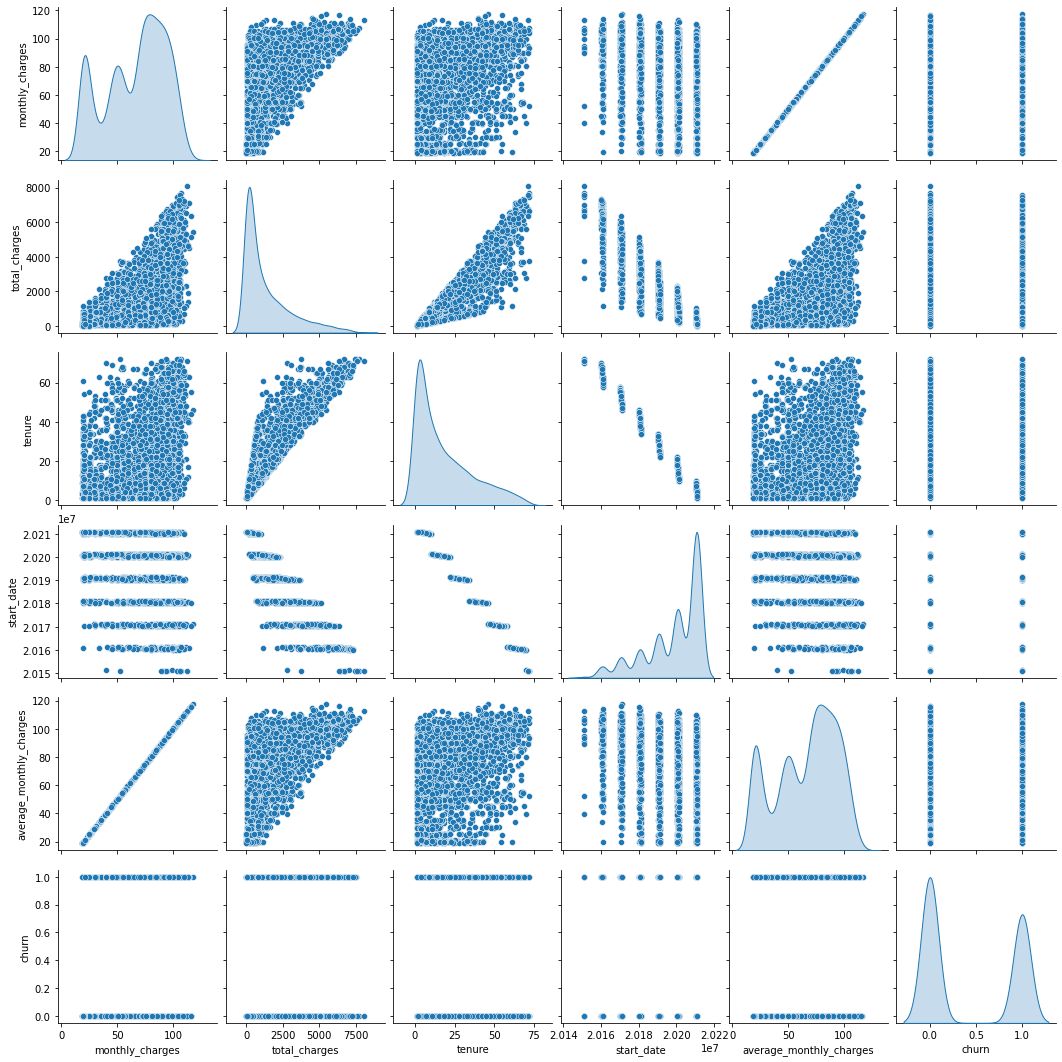

In [47]:
#Separating columns to be visualized
out_cols = list(set(data.nunique()[data.nunique()<6].keys().tolist()
                    + data.select_dtypes(include='object').columns.tolist()))
viz_cols = [x for x in data.columns if x not in out_cols] + ['churn']

sns.pairplot(data[viz_cols], diag_kind="kde")
plt.show()

In [48]:
data.dtypes


is_male                           bool
is_senior_citizen                int64
partner                         object
dependents                      object
phone_service                    int64
internet_service                 int64
contract_type                    int64
payment_type                    object
monthly_charges                float64
total_charges                  float64
churn                             bool
tenure                           int64
is_female                         bool
has_churned                       bool
has_phone                         bool
has_internet                      bool
has_phone_and_internet            bool
partner_dependents               int64
no_partners_no_dependents         bool
no_dependents_yes_partners        bool
dependents_no_partners            bool
yes_dependents_and_partners       bool
Unnamed: 23                    float64
start_date                       int64
average_monthly_charges        float64
validate_monthly_charges 

In [49]:
data.head()

,is_male,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc
12,True,0,No,No,2,1,0,Mailed check,59.9,542.40,...,False,False,False,0.0,20210124,59.9,True,Month-to-Month,Two or More Lines,DSL
13,True,0,No,No,1,2,0,Electronic check,73.9,280.85,...,False,False,False,0.0,20210703,73.9,True,Month-to-Month,One Line,Fiber Optic
14,True,1,Yes,No,1,2,0,Electronic check,98.0,1237.85,...,True,False,False,1.0,20201007,98.0,True,Month-to-Month,One Line,Fiber Optic
15,True,1,Yes,No,1,2,0,Mailed check,83.9,267.40,...,True,False,False,1.0,20210722,83.9,True,Month-to-Month,One Line,Fiber Optic
16,True,0,No,Yes,1,1,0,Credit card (automatic),69.4,571.45,...,False,True,False,2.0,20210218,69.4,True,Month-to-Month,One Line,DSL


In [50]:
X_train.dtypes


is_male                           bool
is_senior_citizen                int64
partner                           bool
dependents                        bool
phone_service                    int64
internet_service                 int64
contract_type                    int64
payment_type                    object
monthly_charges                float64
total_charges                  float64
tenure                           int64
is_female                         bool
has_churned                       bool
has_phone                         bool
has_internet                      bool
has_phone_and_internet            bool
partner_dependents               int64
no_partners_no_dependents         bool
no_dependents_yes_partners        bool
dependents_no_partners            bool
yes_dependents_and_partners       bool
Unnamed: 23                    float64
start_date                       int64
average_monthly_charges        float64
validate_monthly_charges          bool
contract_type_desc       

In [54]:
X_train.head()

,is_male,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,no_dependents_yes_partners,dependents_no_partners,yes_dependents_and_partners,Unnamed: 23,start_date,average_monthly_charges,validate_monthly_charges,contract_type_desc,phone_type_desc,internet_type_desc
5263,True,False,True,True,1,2,0,Mailed check,79.85,887.35,...,False,False,False,0.0,20201122,79.85,True,Month-to-Month,One Line,Fiber Optic
3749,True,True,True,True,2,2,0,Electronic check,85.55,187.45,...,False,False,False,0.0,20210821,85.55,True,Month-to-Month,Two or More Lines,Fiber Optic
4003,True,True,True,True,2,2,0,Electronic check,105.90,6401.25,...,True,False,False,1.0,20161014,105.90,True,Month-to-Month,Two or More Lines,Fiber Optic
5500,True,False,True,True,1,1,0,Electronic check,51.05,415.05,...,False,False,True,3.0,20210221,51.05,True,Month-to-Month,One Line,DSL
5989,True,False,True,True,2,1,0,Electronic check,50.05,50.05,...,False,True,False,2.0,20210926,50.05,True,Month-to-Month,Two or More Lines,DSL


In [52]:
X_train.is_senior_citizen=X_train.is_senior_citizen.astype(bool)

In [60]:
X_train.start_date=X_train.start_date.astype(datetime)

TypeError: Cannot interpret '<module 'datetime' from '/opt/homebrew/anaconda3/lib/python3.8/datetime.py'>' as a data type

In [61]:
data.dtypes

is_male                           bool
is_senior_citizen                int64
partner                         object
dependents                      object
phone_service                    int64
internet_service                 int64
contract_type                    int64
payment_type                    object
monthly_charges                float64
total_charges                  float64
churn                             bool
tenure                           int64
is_female                         bool
has_churned                       bool
has_phone                         bool
has_internet                      bool
has_phone_and_internet            bool
partner_dependents               int64
no_partners_no_dependents         bool
no_dependents_yes_partners        bool
dependents_no_partners            bool
yes_dependents_and_partners       bool
Unnamed: 23                    float64
start_date                       int64
average_monthly_charges        float64
validate_monthly_charges 

In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Removing correlated and unneccessary columns
col_to_drop = []
   
X_text = X_test.drop(columns = col_to_drop, axis = 1)

#target column
target_col = X_test["churn"]

#number of levels in feature to be a categorical feature
nlevels = 6

#Separating categorical and numerical columns
#categorical columns
cat_cols = list(set(data.nunique()[data.nunique()<nlevels].keys().tolist() 
                    + data.select_dtypes(include='object').columns.tolist()))
cat_cols = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols = [x for x in data.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols:
    data[i] = le.fit_transform(data[i])
    X_test[i] = le.transform(X_test[i])

#combining the train and test datasets
trainsize = data.shape[0]
comb = pd.concat((data, data_test), sort=False)

#Duplicating columns for multi value columns
comb = pd.get_dummies(data = comb, columns = multi_cols)

#Separating the train and test datasets
data = comb[:trainsize]
data_test = comb[trainsize:]

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)

scaled_test = std.transform(data_test[num_cols])
scaled_test = pd.DataFrame(scaled_test, columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols, axis = 1)
data = data.merge(scaled, left_index=True, right_index=True, how = "left")

df_data_test_og = data_test.copy()
data_test = data_test.drop(columns = num_cols, axis = 1)
data_test = data_test.merge(scaled_test, left_index=True, right_index=True, how = "left")
3.

KeyError: 'churn'